# Fundamentos de Ciencia de Datos

## Taller 1 

**Nombre:** Alexis Mauricio Garzón Pardo

**Parte 1: Adquisición y limpieza de datos**
* Implementar un script que lea el archivo de datos
* Realizar la limpieza de los datos explicando la lógica de cada decisión
* Subir los datos limpios a una base de datos SQLite

In [15]:
# Importamos las librerias

# Si hace falta instalar alguna librería, descomenta e instala.
#!pip install pandas sqlalchemy openpyxl matplotlib numpy

import os
import pandas as pd
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [16]:
# leer según extensión
data_path="Online Retail.xlsx"
df = pd.read_excel(data_path, engine='openpyxl')
    
print("Archivo cargado:", data_path) #nombre del archivo
print("Dimensiones iniciales:", df.shape) #dimensión del archivo
df.head() # para inspección rápida

Archivo cargado: Online Retail.xlsx
Dimensiones iniciales: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [17]:
# 2. Inspección básica
df.info()
display(df.describe(include='all').T)
print("\nNulos por columna:\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
InvoiceNo,541909.0,25900.0,573585.0,1114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909.0,NaN,NaN,NaN,9.55225,-80995.0,1.0,3.0,10.0,80995.0,218.081158
InvoiceDate,541909,NaN,NaN,NaN,2011-07-04 13:34:57.156386048,2010-12-01 08:26:00,2011-03-28 11:34:00,2011-07-19 17:17:00,2011-10-19 11:27:00,2011-12-09 12:50:00,NaN
UnitPrice,541909.0,NaN,NaN,NaN,4.611114,-11062.06,1.25,2.08,4.13,38970.0,96.759853
CustomerID,406829.0,NaN,NaN,NaN,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Nulos por columna:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [18]:
# 3. Copia para trabajar y evitar modificar el original en memoria
df_clean = df.copy()

# 3.1 Normalizar nombres de columnas 
df_clean.columns = [c.strip() for c in df_clean.columns]

# 3.2 Convertir InvoiceDate a datetime (convertir fechas)
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')
df_clean = df_clean.dropna(subset=['InvoiceDate'])

# 3.3 Quitar filas con InvoiceDate nulo (registro inválido)
df_clean = df_clean[~df_clean['InvoiceDate'].isna()]

# 3.4 Strip en columnas de texto (Description y StockCode)
df_clean['Description'] = df_clean['Description'].astype(str).str.strip()
df_clean['StockCode'] = df_clean['StockCode'].astype(str).str.strip()

# 3.5 Eliminar duplicados exactos (misma fila)
before = df_clean.shape[0]
df_clean = df_clean.drop_duplicates()
after = df_clean.shape[0]
print(f"Duplicados eliminados: {before - after}")

# 3.6 Crear columna para devoluciones y facturas de crédito
df_clean['is_return'] = df_clean['Quantity'] < 0
df_clean['invoice_is_credit'] = df_clean['InvoiceNo'].astype(str).str.contains('C', na=False)


# total price
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

# 3.7 Manejo de CustomerID: muchas filas no tienen CustomerID; si vas a analizar clientes, conviene quitar nulos
print("CustomerID nulos:", df_clean['CustomerID'].isna().sum())
df_with_customer = df_clean.dropna(subset=['CustomerID']).copy()

# 3.8 Opcional: eliminar filas con Quantity == 0 (no aportan venta ni devolución)
df_clean = df_clean[df_clean['Quantity'] != 0]


# 3.9 Quitar Quantity = 0
neg_price = (df_clean['UnitPrice'] < 0).sum()
print("Filas con UnitPrice < 0:", neg_price)

# 3.10 Reset índice final
df_clean = df_clean.reset_index(drop=True)
print("Dimensiones después de limpieza:", df_clean.shape)

Duplicados eliminados: 5268
CustomerID nulos: 135037
Filas con UnitPrice < 0: 2
Dimensiones después de limpieza: (536641, 11)


In [19]:
# 4. Guardar DataFrame limpio en SQLite
db_filename = "online_retail_clean.db"
engine = create_engine(f"sqlite:///{db_filename}", echo=False)

# Guardar tabla 'online_retail'
df_clean.to_sql("online_retail", con=engine, if_exists='replace', index=False)
print(f"Guardado en SQLite: {db_filename} -> tabla 'online_retail' con {df_clean.shape[0]} filas")

Guardado en SQLite: online_retail_clean.db -> tabla 'online_retail' con 536641 filas


In [20]:
# 5. Leer datos desde SQLite para verificar
with engine.connect() as conn:
    df_sql = pd.read_sql_table("online_retail", conn)

print("Dimensiones leídas desde SQLite:", df_sql.shape)
df_sql.head()

Dimensiones leídas desde SQLite: (536641, 11)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,invoice_is_credit,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,False,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,False,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,False,20.34


**Parte 2: EDA**
* Realizar un análisis y una descripción (incluir como archivo de texto) de que información contiene el set de datos. ¿Qué puede decir o cómo puedes describir este set de datos?
* Realizar la lectura de los datos de la base de datos utilizando Python y transformando la tabla a un dataframe de pandas.
* Describir lo encontrado para cada uno de los campos
* ¿Qué meta-data se puede generar?
* Utilizar la documentación del dataset como referencia

In [21]:
# 6.1 Descripción de campos (automática + comentarios)
meta = {}

for col in df_sql.columns:
    ser = df_sql[col]
    info = {
        "dtype": str(ser.dtype),
        "non_null": int(ser.count()),
        "nulls": int(ser.isna().sum()),
        "unique": int(ser.nunique(dropna=True)),
        "sample": ser.dropna().unique()[:5].tolist()
    }
    if pd.api.types.is_numeric_dtype(ser):
        info.update({
            "min": float(ser.min()),
            "max": float(ser.max()),
            "mean": float(ser.mean())
        })
    if pd.api.types.is_datetime64_any_dtype(ser):
        info.update({
            "min_date": str(ser.min()),
            "max_date": str(ser.max())
        })
    meta[col] = info

# Función para serializar Timestamps y numpy
def default_converter(o):
    if isinstance(o, (pd.Timestamp, np.datetime64)):
        return str(o)
    if isinstance(o, np.integer):
        return int(o)
    if isinstance(o, np.floating):
        return float(o)
    return str(o)

with open("metadata_online_retail.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2, ensure_ascii=False, default=default_converter)

print("Metadatos guardados en metadata_online_retail.json")

Metadatos guardados en metadata_online_retail.json


In [22]:
# 7. Estadísticas globales útiles
# Rango temporal
date_min, date_max = df_sql['InvoiceDate'].min(), df_sql['InvoiceDate'].max()

# Revenue sin devoluciones
total_revenue = df_sql.loc[~df_sql['is_return'], 'TotalPrice'].sum()

# Top productos
top_products = (df_sql.loc[~df_sql['is_return']]
                .groupby('Description')['TotalPrice']
                .sum()
                .sort_values(ascending=False)
                .head(10))

# Top países
top_countries = (df_sql.loc[~df_sql['is_return']]
                 .groupby('Country')['TotalPrice']
                 .sum()
                 .sort_values(ascending=False)
                 .head(10))

print("Rango temporal:", date_min, "->", date_max)
print("Revenue total (excl. devoluciones):", total_revenue)
print("\nTop 10 productos:\n", top_products)
print("\nTop 10 países:\n", top_countries)

Rango temporal: 2010-12-01 08:26:00 -> 2011-12-09 12:50:00
Revenue total (excl. devoluciones): 10619986.684

Top 10 productos:
 Description
DOTCOM POSTAGE                        206248.77
REGENCY CAKESTAND 3 TIER              174156.54
PAPER CRAFT , LITTLE BIRDIE           168469.60
WHITE HANGING HEART T-LIGHT HOLDER    106236.72
PARTY BUNTING                          99445.23
JUMBO BAG RED RETROSPOT                94159.81
MEDIUM CERAMIC TOP STORAGE JAR         81700.92
POSTAGE                                78101.88
Manual                                 77752.82
RABBIT NIGHT LIGHT                     66870.03
Name: TotalPrice, dtype: float64

Top 10 países:
 Country
United Kingdom    8979619.974
Netherlands        285446.340
EIRE               283140.520
Germany            228678.400
France             209625.370
Australia          138453.810
Spain               61558.560
Switzerland         57067.600
Belgium             41196.340
Sweden              38367.830
Name: TotalPrice, dtyp

**Parte 3: Visualización**
* Implemetar tres técnicas de visualización que ayuden a entender el
comportamiento del set de datos. Explorar opciones avanzadas de
visualización. Describir textualmente cuál es la historia que cuentan las
gráficas.
* Guardar todas las visualizaciones como archivos de imágenes en el mismo
directorio.

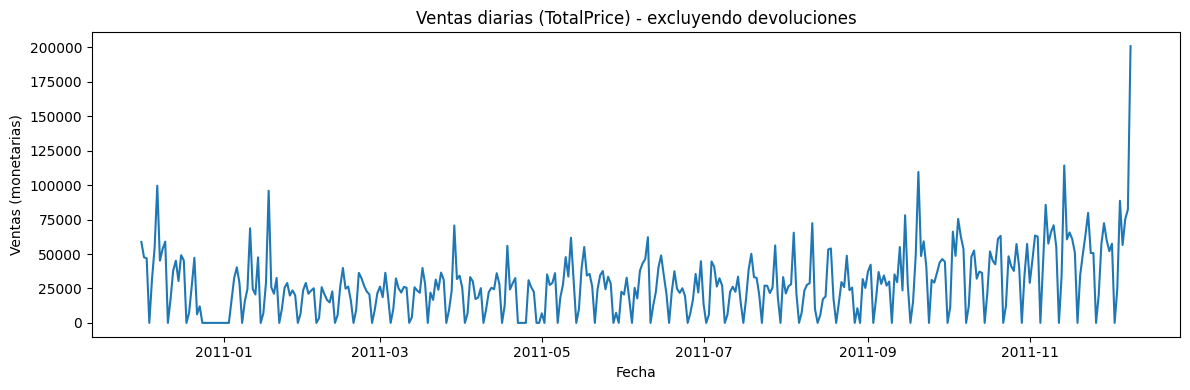

In [23]:
# A. Serie temporal: ventas diarias (suma TotalPrice por día, excluyendo devoluciones)
daily = (df_sql.loc[~df_sql['is_return']]
         .set_index('InvoiceDate')
         .resample('D')['TotalPrice']
         .sum()
         .fillna(0))

plt.figure(figsize=(12,4))
plt.plot(daily.index, daily.values)   # trazo de la serie
plt.title("Ventas diarias (TotalPrice) - excluyendo devoluciones")
plt.xlabel("Fecha")
plt.ylabel("Ventas (monetarias)")
plt.tight_layout()
plt.savefig("ventas_diarias.png", dpi=150)
plt.show()

**Observación:** Se observa un incremento marcado en noviembre-diciembre, lo que sugiere un fuerte efecto estacional vinculado a compras navideñas.

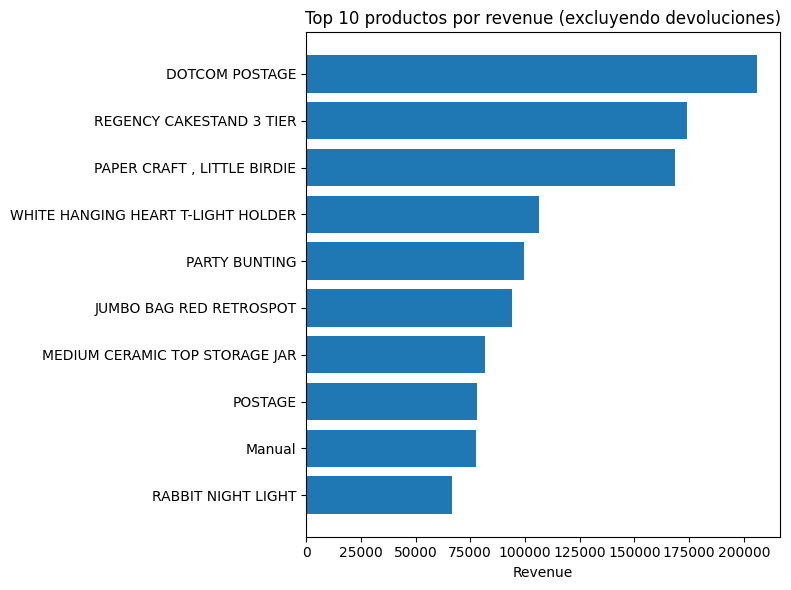

In [24]:
# B. Top 10 productos por revenue (barras horizontales)
top10 = top_products.sort_values()  # ordenar ascendente para barh
plt.figure(figsize=(8,6))
plt.barh(top10.index, top10.values)
plt.title("Top 10 productos por revenue (excluyendo devoluciones)")
plt.xlabel("Revenue")
plt.tight_layout()
plt.savefig("top10_productos.png", dpi=150)
plt.show()

**Observación:** El producto con mayor revenue es DOTCOM POSTAGE con 206k, seguido de artículos decorativos como REGENCY CAKESTAND, PAPER CRAFT, LITTLE BIRDIE y WHITE HANGING HEART T-LIGHT HOLDER. El revenue no se concentra solo en un producto, sino en una mezcla de utilitarios y decorativos.

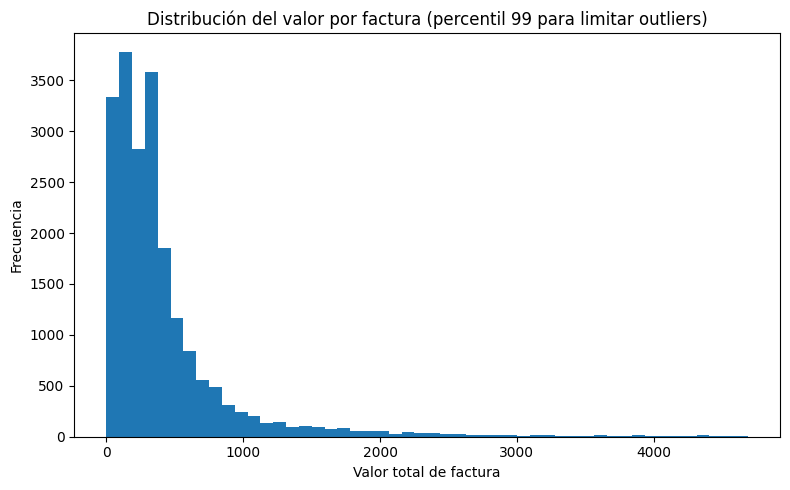

In [25]:
# C. Distribución de valor por factura (InvoiceNo) - resumimos por invoice
invoice_totals = (df_sql.loc[~df_sql['is_return']]
                  .groupby('InvoiceNo')['TotalPrice']
                  .sum())

plt.figure(figsize=(8,5))
plt.hist(invoice_totals.values, bins=50, range=(0, invoice_totals.quantile(0.99)))
plt.title("Distribución del valor por factura (percentil 99 para limitar outliers)")
plt.xlabel("Valor total de factura")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.savefig("histograma_valor_factura.png", dpi=150)
plt.show()

**Observación:** La mayoría de facturas se concentran en montos bajos (<300), mientras que hay pocas facturas con valores muy altos (outliers). Esto revela que la empresa vive de muchos pedidos pequeños y pocos grandes.

In [26]:
# Archivos generados:
generated = [
    "online_retail_clean.db",
    "metadata_online_retail.json",
    "dataset_description.txt",
    "ventas_diarias.png",
    "top10_productos.png",
    "histograma_valor_factura.png"
]
print("Archivos generados (revisa el directorio):")
for g in generated:
    print(" -", g)

Archivos generados (revisa el directorio):
 - online_retail_clean.db
 - metadata_online_retail.json
 - dataset_description.txt
 - ventas_diarias.png
 - top10_productos.png
 - histograma_valor_factura.png
